In [1]:
import numpy as np
import pandas as pd
import os
import gym
import random
from gym import spaces
import torch
import matplotlib.pyplot as plt
from Environment import DiagnosisEnv
from Agent import train_DQN

In [2]:
df_symptoms = pd.read_csv("Data/Symptoms.csv")
df_exams = pd.read_csv("Data/Examinations.csv")
df_gen_surgery_diagnoses = pd.read_csv("Data/Gen_Surgery_Diagnosis.csv")

In [10]:
env = DiagnosisEnv(df_symptoms, df_exams, df_gen_surgery_diagnoses)
agent, rewards, success_rates, examinations_per_diagnosis = train_DQN(env, episodes=5000)

In [4]:
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

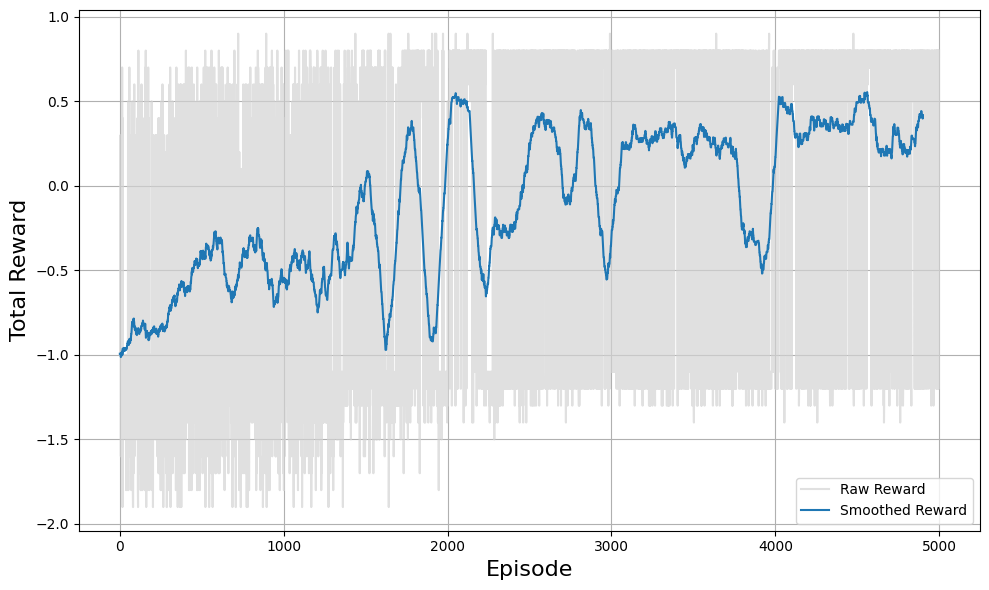

In [11]:
smoothed_rewards = moving_average(rewards, window_size=100)
plt.figure(figsize=(10,6))
plt.plot(rewards, color="lightgray", label="Raw Reward", alpha=0.7)
plt.plot(range(len(smoothed_rewards)), smoothed_rewards, label="Smoothed Reward")
plt.xlabel("Episode", fontsize=16)
plt.ylabel("Total Reward", fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

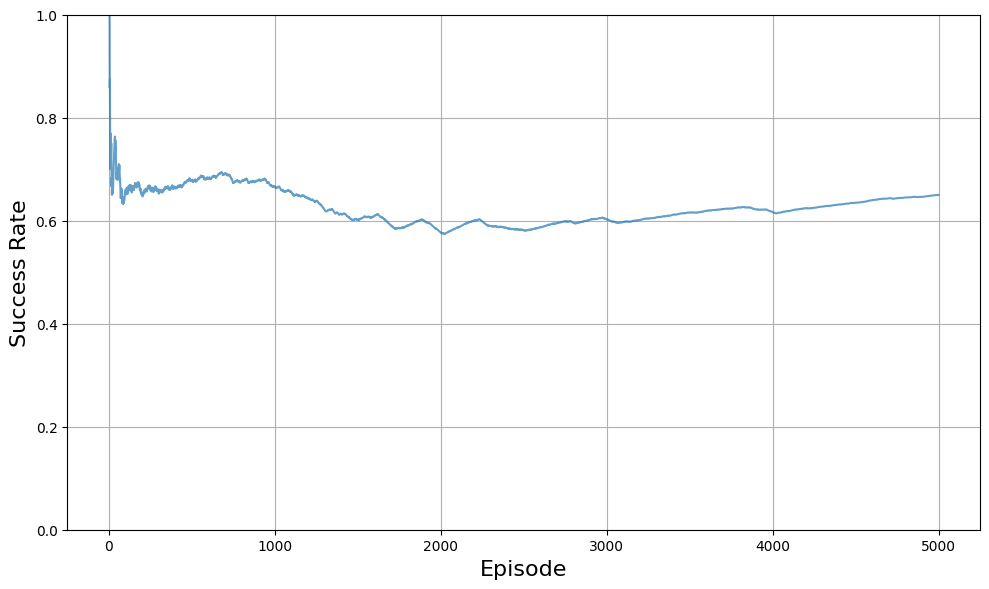

Diagnosis Success Rate: 64.98%


In [13]:
plt.figure(figsize=(10,6))
plt.plot(success_rates, alpha=0.7)
plt.xlabel("Episode", fontsize=16)
plt.ylabel("Success Rate", fontsize=16)
plt.ylim(0,1)
plt.grid(True)
plt.tight_layout()
plt.show()
print("Diagnosis Success Rate: " + str(round(success_rates[-1] * 100,2)) + "%")

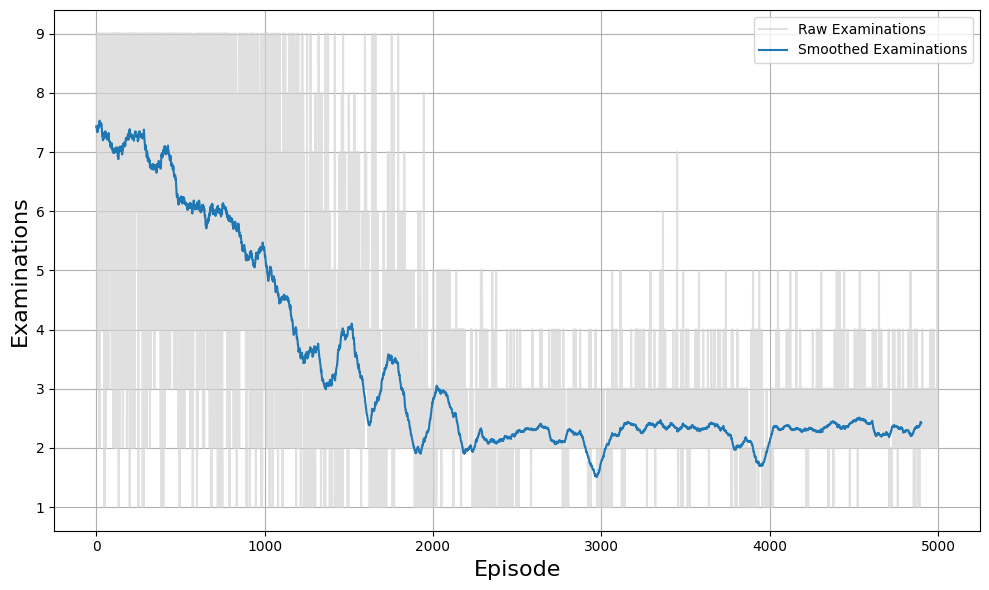

Average Examination per Diagnosis: 2.42


In [14]:
smoothed_examinations = moving_average(examinations_per_diagnosis, window_size=100)
plt.figure(figsize=(10,6))
plt.plot(examinations_per_diagnosis, color="lightgray", label="Raw Examinations", alpha=0.7)
plt.plot(range(len(smoothed_examinations)), smoothed_examinations, label="Smoothed Examinations")
plt.xlabel("Episode", fontsize=16)
plt.ylabel("Examinations", fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("Average Examination per Diagnosis: " + str(round(smoothed_examinations[-1],2)))

In [15]:
def test_agent(env, agent, num_patients=10):
    number_of_diagnoses = len(df_gen_surgery_diagnoses)
    print("General Surgery Department, Number of possible Diagnosis: " + str(number_of_diagnoses))
    overall_correct_diagnoses = 0
    for num in range(number_of_diagnoses):
        correct_diagnoses = 0
        for patient_num in range(num_patients):
            state = env.set(num)
    
            exams_taken = []
            symptoms_history = []
    
            done = False
            step_count = 0
    
            while not done:
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                with torch.no_grad():
                    q_values = agent(state_tensor).squeeze()
                action = q_values.argmax().item()
                exam_taken = env.examinations[action]
    
                state, reward, done, info = env.step(action)
                observed_symptoms = env.get_observed_symptoms()
    
                exams_taken.append(exam_taken)
                symptoms_history.append(observed_symptoms)
    
                if info.get("forced", False):
                    if info["guess"] == info["diagnosis"]:
                        correct_diagnoses += 1
                        overall_correct_diagnoses += 1
                    break
    
                step_count += 1
    
        accuracy = correct_diagnoses / num_patients
        print(df_gen_surgery_diagnoses.loc[num,'Diagnosis'].capitalize() + " - Accuracy over " + str(num_patients) + " patients: " + str(accuracy))
    print("General Surgery Department - Overall Accuracy: " + str(round(overall_correct_diagnoses / (num_patients * number_of_diagnoses) * 100,2)) + "%")

In [25]:
test_agent(env, agent, num_patients=100)

General Surgery Department, Number of possible Diagnosis: 46
Acute renal failure - Accuracy over 100 patients: 1.0
Appendicitis - Accuracy over 100 patients: 1.0
Bacterial gastroenteritis - Accuracy over 100 patients: 0.95
Blunt pancreas laceration - Accuracy over 100 patients: 1.0
Blunt spleen rupture - Accuracy over 100 patients: 0.99
Calculus in bladder - Accuracy over 100 patients: 1.0
Calculus of ureter - Accuracy over 100 patients: 0.8
Campylobacteriosis - Accuracy over 100 patients: 0.99
Cholangitis - Accuracy over 100 patients: 1.0
Cholecystitis - Accuracy over 100 patients: 0.99
Chronic kidney disease - Accuracy over 100 patients: 0.98
Cirrhosis - Accuracy over 100 patients: 0.97
Coeliac disease - Accuracy over 100 patients: 0.98
Crohn's disease - Accuracy over 100 patients: 0.86
Duodenitis - Accuracy over 100 patients: 0.54
Esophageal varices - Accuracy over 100 patients: 0.41
Esophagitis - Accuracy over 100 patients: 0.93
Exocrine pancreatic insufficiency - Accuracy over 100

In [17]:
def test_diagnosis(env, agent, diagnosis, num_patients=5):
    int_diagnosis = int(df_gen_surgery_diagnoses.index[df_gen_surgery_diagnoses["Diagnosis"] == diagnosis].tolist()[0])
    correct_diagnoses = 0
    for patient_num in range(num_patients):
        state = env.set(int_diagnosis)

        print("\nPATIENT " + str(patient_num + 1))
        print("TRUE DIAGNOSIS: " + str(env.get_true_diagnosis()))
        print("TRUE SYMPTOMS (Generated for this patient): " + str(env.get_true_symptoms()) + "\n")

        exams_taken = []
        symptoms_history = []

        done = False
        step_count = 0

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                q_values = agent(state_tensor).squeeze()
            action = q_values.argmax().item()
            exam_taken = env.examinations[action]

            state, reward, done, info = env.step(action)
            observed_symptoms = env.get_observed_symptoms()

            exams_taken.append(exam_taken)
            symptoms_history.append(observed_symptoms)

            if info.get("forced", False):
                print("\nGuessed Diagnosis: " + str(info['guess'].capitalize()))
                if info["guess"] == info["diagnosis"]:
                    correct_diagnoses += 1
                break
                
            print("Step " + str(step_count + 1))
            print("Examination taken: " + str(exam_taken))
            print("Symptoms uncovered so far: " + str(observed_symptoms))

            step_count += 1
    
    accuracy = correct_diagnoses / num_patients
    print(str(diagnosis.capitalize()) + ": Accuracy over " + str(num_patients) + " patients: " + str(accuracy))

In [24]:
test_diagnosis(env, agent, "exocrine pancreatic insufficiency", 5)


PATIENT 1
TRUE DIAGNOSIS: exocrine pancreatic insufficiency
TRUE SYMPTOMS (Generated for this patient): ['fat malabsorption', 'excessive flatulence', 'steatorrhea', 'vitamin deficiency', 'weight loss', 'elastase - low level']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['excessive flatulence', 'weight loss']
Step 2
Examination taken: stool analysis testing
Symptoms uncovered so far: ['excessive flatulence', 'steatorrhea', 'weight loss']
Step 3
Examination taken: fecal elastase test testing
Symptoms uncovered so far: ['excessive flatulence', 'steatorrhea', 'weight loss', 'elastase - low level']
Step 4
Examination taken: echo
Symptoms uncovered so far: ['excessive flatulence', 'steatorrhea', 'weight loss', 'elastase - low level']

Guessed Diagnosis: Exocrine pancreatic insufficiency

PATIENT 2
TRUE DIAGNOSIS: exocrine pancreatic insufficiency
TRUE SYMPTOMS (Generated for this patient): ['abdominal pain', 'fat malabsorption', 'excessive flatulence', 'weight loss', 'el

In [21]:
test_diagnosis(env, agent, "fistula of the intestine", 5)


PATIENT 1
TRUE DIAGNOSIS: fistula of the intestine
TRUE SYMPTOMS (Generated for this patient): ['abdominal pain', 'bloating', 'diarrhea', 'intestinal fistula']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['abdominal pain', 'bloating', 'diarrhea']
Step 2
Examination taken: usg
Symptoms uncovered so far: ['abdominal pain', 'bloating', 'diarrhea']

Guessed Diagnosis: Crohn's disease

PATIENT 2
TRUE DIAGNOSIS: fistula of the intestine
TRUE SYMPTOMS (Generated for this patient): ['bloating', 'dehydration', 'diarrhea', 'intestinal fistula']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['bloating', 'diarrhea']
Step 2
Examination taken: usg
Symptoms uncovered so far: ['bloating', 'diarrhea']

Guessed Diagnosis: Bacterial gastroenteritis

PATIENT 3
TRUE DIAGNOSIS: fistula of the intestine
TRUE SYMPTOMS (Generated for this patient): ['abdominal pain', 'dehydration', 'diarrhea', 'intestinal fistula']

Step 1
Examination taken: interview
Symptoms uncovered s

In [22]:
test_diagnosis(env, agent, "interstitial cystitis", 5)


PATIENT 1
TRUE DIAGNOSIS: interstitial cystitis
TRUE SYMPTOMS (Generated for this patient): ['abdominal pain', 'bladder lining defect']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['abdominal pain']
Step 2
Examination taken: usg
Symptoms uncovered so far: ['abdominal pain']

Guessed Diagnosis: Acute renal failure

PATIENT 2
TRUE DIAGNOSIS: interstitial cystitis
TRUE SYMPTOMS (Generated for this patient): ['bladder lining defect']

Step 1
Examination taken: interview
Symptoms uncovered so far: []

Guessed Diagnosis: Acute renal failure

PATIENT 3
TRUE DIAGNOSIS: interstitial cystitis
TRUE SYMPTOMS (Generated for this patient): ['frequent urination', 'urinary urgency', 'bladder lining defect']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['frequent urination', 'urinary urgency']
Step 2
Examination taken: biopsy testing
Symptoms uncovered so far: ['frequent urination', 'urinary urgency', 'bladder lining defect']
Step 3
Examination taken: ecg
Symptom